In [1]:
from tifffile import imread
import os
from matplotlib import pyplot as plt
import json
from scipy.io import loadmat
import h5py
import numpy as np

In [2]:
pth_WSI_segmentations = r'\\10.99.68.178\andreex\data\Stardist\PDAC model\maybe_all_tiles_donald\test_WSI\StarDist_2_9_24\json'
npdi_im_path = r'\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2'

In [3]:
json_pth_list = sorted([os.path.join(pth_WSI_segmentations,file) for file in os.listdir(pth_WSI_segmentations) if file.endswith(".json")])
print(json_pth_list)

['\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\maybe_all_tiles_donald\\test_WSI\\StarDist_2_9_24\\json\\PD_11 2O LC.json', '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\maybe_all_tiles_donald\\test_WSI\\StarDist_2_9_24\\json\\PD_12 1F LCM-1-.json', '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\maybe_all_tiles_donald\\test_WSI\\StarDist_2_9_24\\json\\PD_14 1F LC.json', '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\maybe_all_tiles_donald\\test_WSI\\StarDist_2_9_24\\json\\PD_15 3Q LC.json', '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\maybe_all_tiles_donald\\test_WSI\\StarDist_2_9_24\\json\\PD_16 5l LCM-.json', '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\maybe_all_tiles_donald\\test_WSI\\StarDist_2_9_24\\json\\PD_17 4M LC.json', '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\maybe_all_tiles_donald\\test_WSI\\StarDist_2_9_24\\json\\PD_18 2H LC.json', '\\\\10.99.68.178\\andreex\\data\\Stardist\\PDAC model\\maybe_all_til

In [4]:
im_list = sorted(os.listdir(npdi_im_path))
im_list = [im for im in im_list if im.endswith('.tif')]
# im_list = [im for im in im_list if im.endswith('.ndpi')]
print(im_list)

['PD_11 2O LCM.tif', 'PD_12 1F LCM-1-1.tif', 'PD_14 1F LCM.tif', 'PD_15 3Q LCM.tif', 'PD_16 5l LCM-2.tif', 'PD_17 4M LCM.tif', 'PD_18 2H LCM.tif', 'PD_19 5M LCM.tif', 'PD_2 5N-T LCM.tif', 'PD_20 3II LCM.tif', 'PD_21 5M-2 LCM.tif', 'PD_22 5L LCM.tif', 'PD_23 4O LCM.tif', 'PD_24 2L LCM.tif', 'PD_25 3GG LCM.tif', 'PD_26 2K LCM.tif', 'PD_27 4N LCM rescan.tif', 'PD_28 4T LCM - Copy.tif', 'PD_28 4T LCM.tif', 'PD_30 3D LCM.tif', 'PD_31 4N LCM - Copy.tif', 'PD_31 4N LCM.tif', 'PD_4 3L-1 LCM.tif', 'PD_8 1F LCM.tif', 'PD_9 2O LCM.tif']


In [5]:
#from glob import glob

#im_list = glob(im_list)

In [6]:
# read one image
ind = 0

HE_20x_WSI = imread(os.path.join(npdi_im_path, im_list[ind]))

In [7]:
crop_x = 24218
crop_y = 28381
tile_size = 512*4

HE_20x_tile = HE_20x_WSI[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

In [8]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()

In [9]:
def adjust_contours(contours_matched, x, y):

    contours_matched_adjusted = []
    for i in range(len(contours_matched)):
        contour = contours_matched[i][0]
        x_coords = contour[0]
        y_coords = contour[1]
        x_coords = [point-x for point in x_coords]
        y_coords = [point-y for point in y_coords]
        
        shape = list(zip(x_coords, y_coords))
        contours_matched_adjusted.append(shape)
    
    return contours_matched_adjusted

In [10]:
def adjust_coords_and_plot(centroids, contours, crop_x, crop_y, cropped_HE_im):
    centroids_total_np = np.array(centroids)
    adj_centroids = [[pair[0] - crop_y, pair[1] - crop_x] for pair in centroids]
    centroids_in_tile = [pair for pair in adj_centroids if 0 < pair[0] < tile_size and 0 < pair[1] < tile_size]
    
    indices_matched = [adj_centroids.index(pair) for pair in adj_centroids if pair in centroids_in_tile]
    
    contours_in_tile = [contours[i] for i in indices_matched]

    contours_in_tile_adjusted = adjust_contours(contours_in_tile, crop_y, crop_x)
    
    reversed_contours = [[(y, x) for x, y in polygon] for polygon in contours_in_tile_adjusted]

    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot the image
    ax.imshow(cropped_HE_im)
    ax.set_axis_off()
    
    for polygon in reversed_contours:
        x_coords, y_coords = zip(*polygon)
        x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
        y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon
    
        color = 'red'
        
        skip = False
        for x in x_coords:
            if x < 0 or x > (tile_size - 1):
                skip = True
                break
        for y in y_coords:
            if y < 0 or y > (tile_size - 1):
                skip = True
                break
        
        if not skip:
    
            ax.plot(x_coords, y_coords, alpha=0.4, color=color)
            ax.fill(x_coords, y_coords, alpha=0.4, color=color)  # Fill the polygon
    
    # Set labels and title for the plot
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('StarDist Segmentation')
    
    plt.show()

In [11]:
def adjust_contours(contours_matched, x, y):

    contours_matched_adjusted = []
    for i in range(len(contours_matched)):
        contour = contours_matched[i][0]
        x_coords = contour[0]
        y_coords = contour[1]
        x_coords = [point-x for point in x_coords]
        y_coords = [point-y for point in y_coords]
        
        shape = list(zip(x_coords, y_coords))
        contours_matched_adjusted.append(shape)
    
    return contours_matched_adjusted

In [12]:
segmentation_data = json.load(open(json_pth_list[ind]))

centroids = [nuc['centroid'][0] for nuc in segmentation_data]
contours = [nuc['contour'] for nuc in segmentation_data]
print(len(centroids))
print(len(contours))

681966
681966


In [13]:
os.path.join(npdi_im_path, im_list[ind])

'\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\PD_11 2O LCM.tif'

In [21]:
np.shape(HE_20x_WSI)

(47457, 70896, 3)

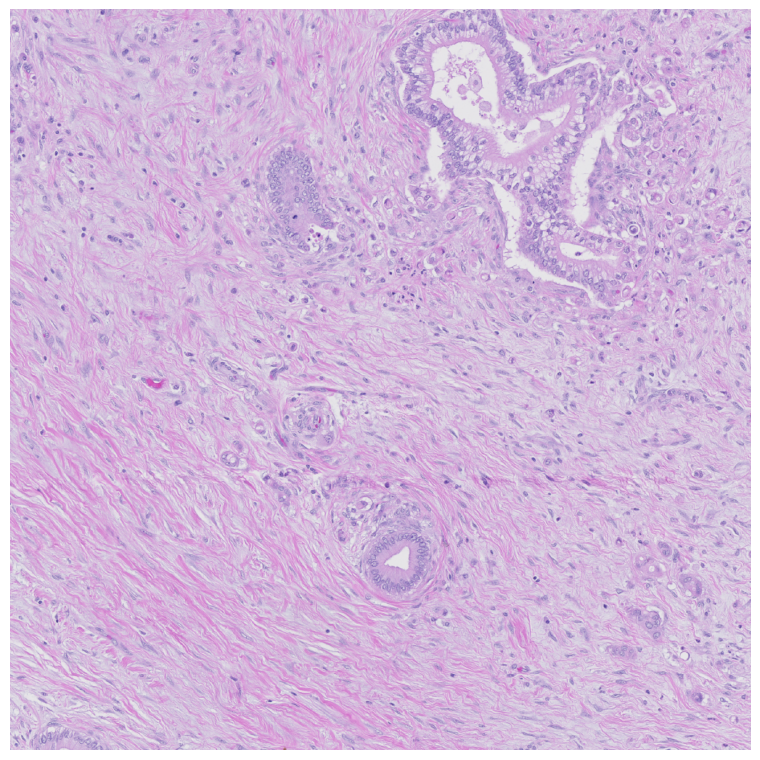

In [27]:
# neutrophils on first image in the folder idk which one
#crop_x = 7414
#crop_y = 17113
#tile_size = 500

crop_x = 30000
crop_y = 33000
tile_size = 512*4

HE_20x_tile = HE_20x_WSI[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()
    
show_tile(HE_20x_tile)

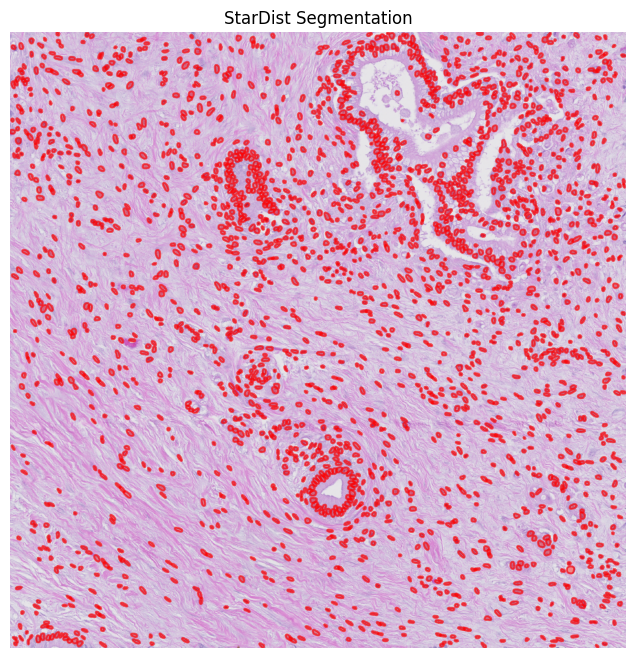

In [28]:
adjust_coords_and_plot(centroids, contours, crop_x, crop_y, HE_20x_tile)

In [40]:
# downsample for andre

def show_tile_ds(tile, ds):
    """Plot a single image."""
    shp_tile = np.shape(tile)
    tile = tile[0:shp_tile[0]:ds, 0:shp_tile[1]:ds]
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()

In [63]:
def adjust_coords_and_plot_ds(centroids, contours, crop_x, crop_y, cropped_HE_im, ds):
    centroids_total_np = np.array(centroids)
    adj_centroids = [[(pair[0] - crop_y)/ds, (pair[1] - crop_x)/ds] for pair in centroids]
    centroids_in_tile = [pair for pair in adj_centroids if 0 < pair[0] < tile_size/ds and 0 < pair[1] < tile_size/ds]
    
    indices_matched = [adj_centroids.index(pair) for pair in adj_centroids if pair in centroids_in_tile]
    
    contours_in_tile = [contours[i] for i in indices_matched]

    contours_in_tile_adjusted = adjust_contours(contours_in_tile, crop_y, crop_x)
    
    reversed_contours = [[(y/ds, x/ds) for x, y in polygon] for polygon in contours_in_tile_adjusted]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    # Plot the image
    ax.imshow(cropped_HE_im)
    ax.set_axis_off()
    
    for polygon in reversed_contours:
        x_coords, y_coords = zip(*polygon)
        x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
        y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon
    
        color = 'red'
        
        skip = False
        for x in x_coords:
            if x < 0 or x > (tile_size/ds - 1):
                skip = True
                break
        for y in y_coords:
            if y < 0 or y > (tile_size/ds - 1):
                skip = True
                break
        
        if not skip:
    
            ax.plot(x_coords, y_coords, alpha=0.4, color=color)
            ax.fill(x_coords, y_coords, alpha=0.4, color=color)  # Fill the polygon
    
    # Set labels and title for the plot
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('StarDist Segmentation')
    
    plt.show()

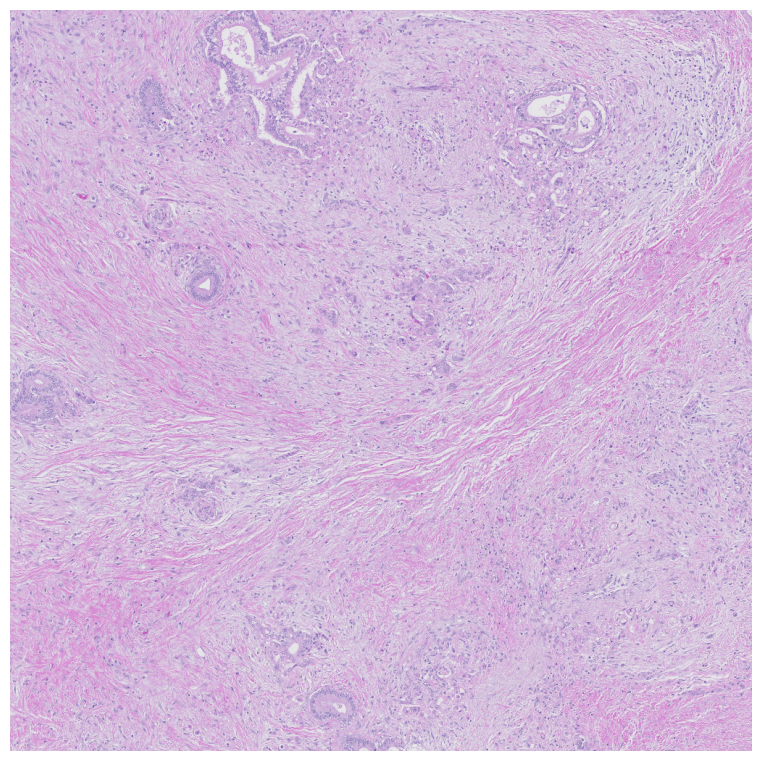

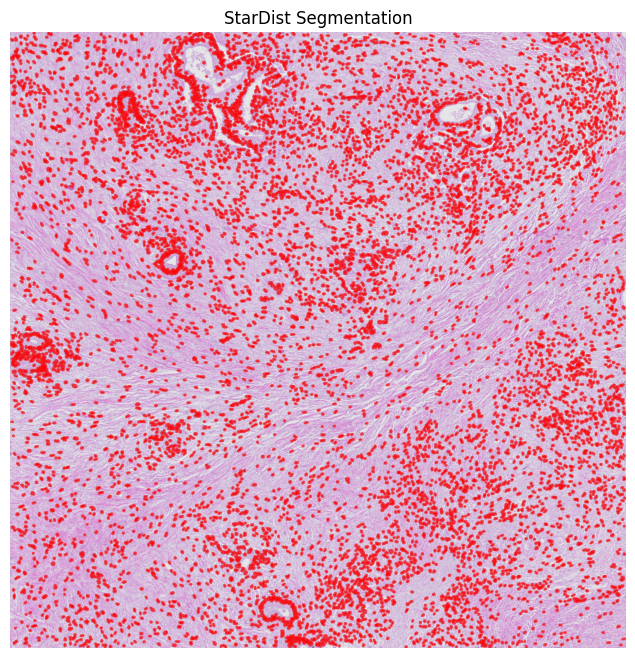

In [66]:
crop_x = 30000
crop_y = 33000
tile_size = 512*8
HE_20x_tile = HE_20x_WSI[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

ds = 4
shp_tile = np.shape(HE_20x_WSI)
tile = HE_20x_tile[0:shp_tile[0]:ds, 0:shp_tile[1]:ds]
show_tile(tile)
adjust_coords_and_plot_ds(centroids, contours, crop_x, crop_y, tile, ds)